In [1]:
import sys
import numpy as np
import json
import os
import pickle
import logging
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.layers import Input,AveragePooling2D, Concatenate, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from skimage.transform import resize
from tensorflow.keras.optimizers import Adam, RMSprop,SGD
from tensorflow.keras.initializers import RandomNormal
from functools import partial

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array,array_to_img
import keras
from tensorflow.keras.applications.vgg19 import VGG19

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [6]:
# Load data train

In [7]:
DATA_DIR = './data_train/data_get_latent/'
with open(os.path.join(DATA_DIR,"data_face_vis.pkl"), "rb") as input_file:
    data_train_face = pickle.load(input_file)
with open(os.path.join(DATA_DIR,"data_fingerprint_vis.pkl"), "rb") as input_file:
    data_train_finger = pickle.load(input_file)
with open(os.path.join(DATA_DIR,"data_dir_vis.pkl"), "rb") as input_file:
    data_train_dir = pickle.load(input_file)

In [8]:
data_train_face.shape,data_train_finger.shape

((3571, 256, 256, 3), (3571, 256, 256, 1))

In [9]:
data_train_finger = ((data_train_finger)/np.max(data_train_finger))
data_train_finger = np.where(data_train_finger > .5, 1.0, 0.0).astype('float32')

In [10]:
np.max(data_train_face), data_train_face.dtype

(255, dtype('uint8'))

In [11]:
# for i in range(15):
#     print(data_train_dir[i])
#     plt.subplot(1, 2, 1)
#     plt.imshow(data_train_face[i])
#     plt.subplot(1, 2, 2)
#     plt.imshow(data_train_finger[i])
#     plt.show()


In [12]:
# Load model VAE

In [13]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
encoder_model = tf.keras.models.load_model("../VAE_model/model_save/model_multivae/encoder_multi.h5", \
                                                       custom_objects={"Sampling":Sampling})
decoder_model = tf.keras.models.load_model("../VAE_model/model_save/model_multivae/decoder_multi.h5", \
                                                       custom_objects={"Sampling":Sampling})

In [15]:
# Get latent code

In [16]:
latent_code = encoder_model.predict(data_train_finger)[2]

In [17]:
latent_code.shape

(3571, 256)

In [18]:
# create label

In [19]:
y = []
label = 0
pre_id = 11023
for i,dir_image in enumerate(data_train_dir):
    name_image = dir_image.split('/')[-1].split('_')[-1].split('.')[0]
    if name_image[-1]=="t":
        id_image = float((name_image[2:-5]))
    else:
        id_image= float((name_image[2:-4]))
    if abs(id_image-pre_id) !=0:
        pre_id = id_image
        label +=1
    y.append(label)
y = np.asarray(y)

In [20]:
y[0:10]

array([0, 0, 1, 2, 3, 4, 4, 5, 6, 6])

In [21]:
# y = []
# X = []
# label = 0
# pre_id = 11023
# for i,dir_image in enumerate(data_train_dir):
#     name_image = dir_image.split('/')[-1].split('_')[-1].split('.')[0]
#     if name_image[-1]=="t":
#         id_image = float((name_image[2:-5]))
#     else:
#         id_image= float((name_image[2:-4]))
#     if abs(id_image-pre_id) == 0:
#         label +=1
#     pre_id = id_image
#     y.append(label)
# y = np.asarray(y)

In [22]:
x_data = latent_code[:50]
y_label = y[:50]

In [23]:
# plot 2D

In [24]:
pca = decomposition.PCA(n_components=2)
pca.fit(x_data)
X = pca.transform(x_data)

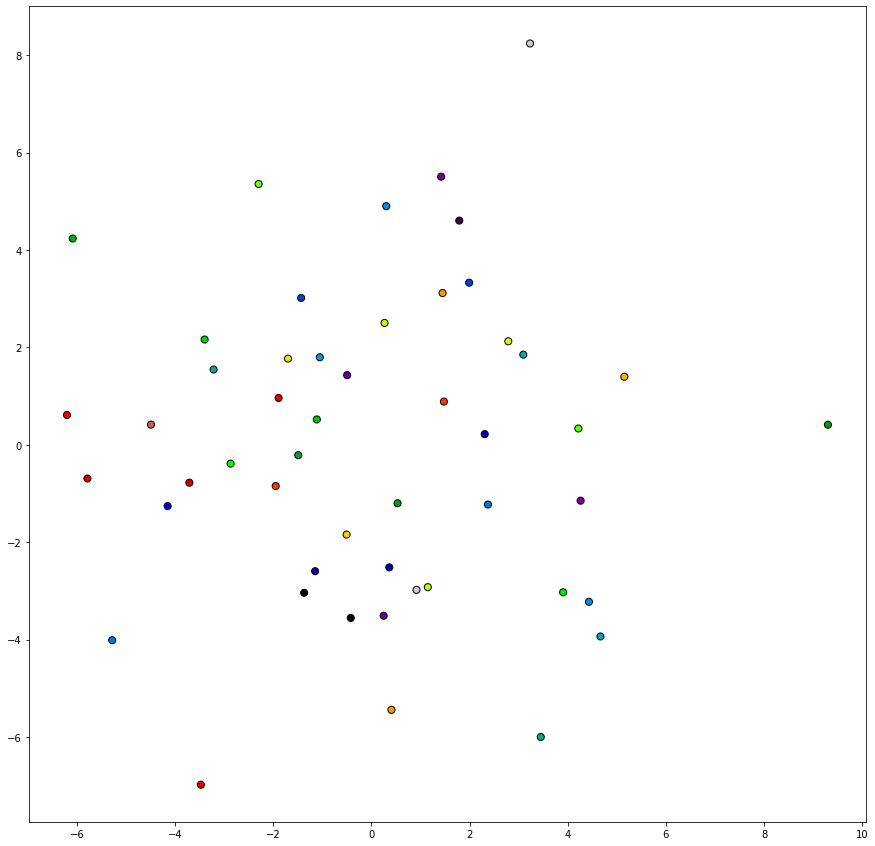

In [25]:
plt.figure(2, figsize=(15, 15))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y_label, cmap=plt.cm.nipy_spectral,
            edgecolor='k',s=50,plotnonfinite=False)
#plt.savefig("./plot/plot_2D_"+str(X.shape[0]))
#for i, label in enumerate(y_label):
#    plt.annotate(label, (X[i, 0], X[i, 1]),fontsize=12)
plt.show()

In [26]:
# plot 3D

In [27]:
pca = decomposition.PCA(n_components=3)
pca.fit(x_data)
X = pca.transform(x_data)

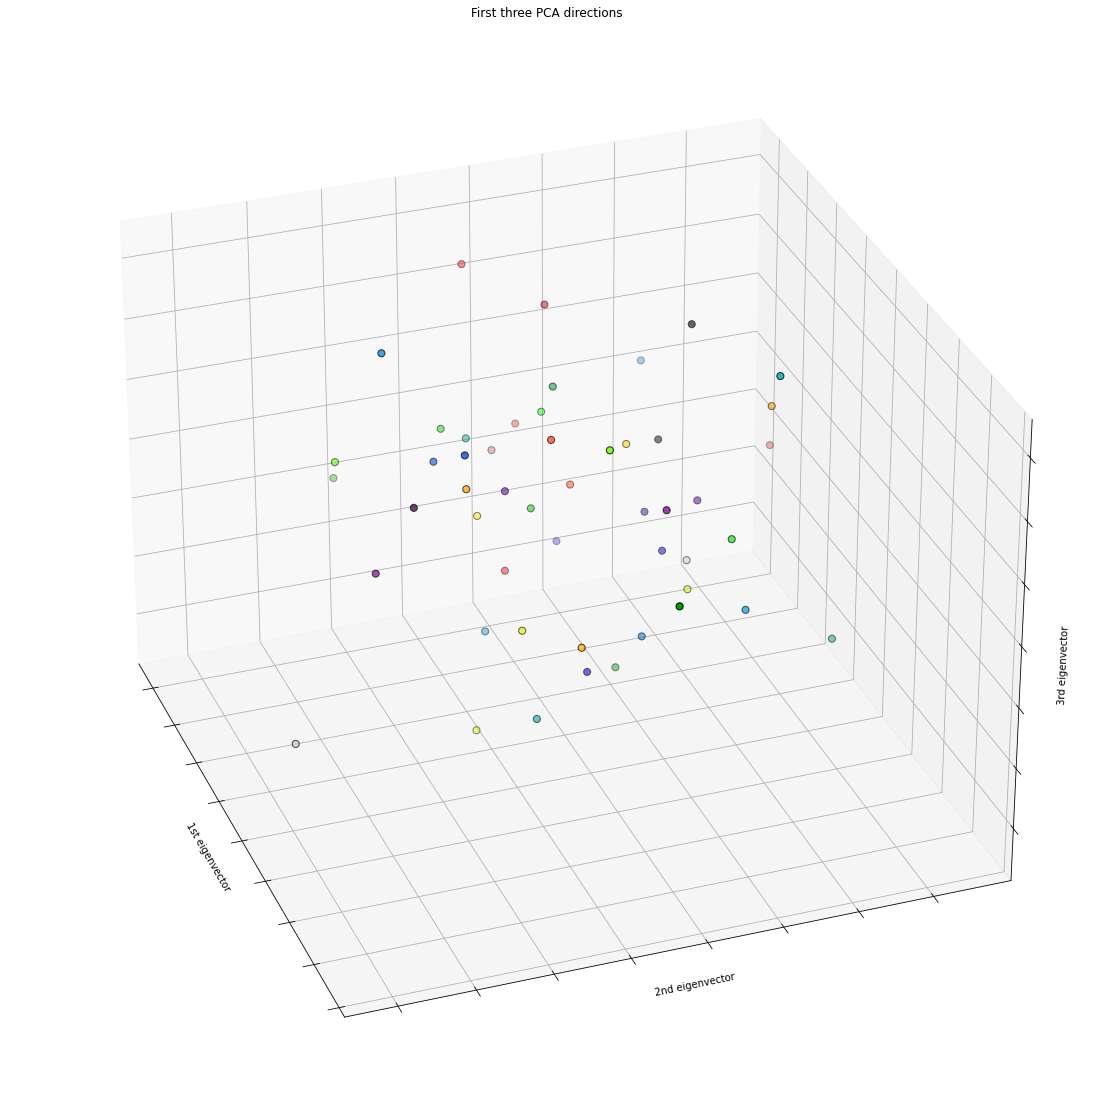

In [33]:
fig = plt.figure(1, figsize=(15, 15))
ax = Axes3D(fig, elev=-150, azim=200)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_label,
           cmap=plt.cm.nipy_spectral, edgecolor='k', s=50)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([]) 
#ax.savefig("./plot/plot_3D_"+str(X.shape[0])+'.pdf')
plt.show()

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_data)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 7.499994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.873104
[t-SNE] KL divergence after 300 iterations: 0.880364


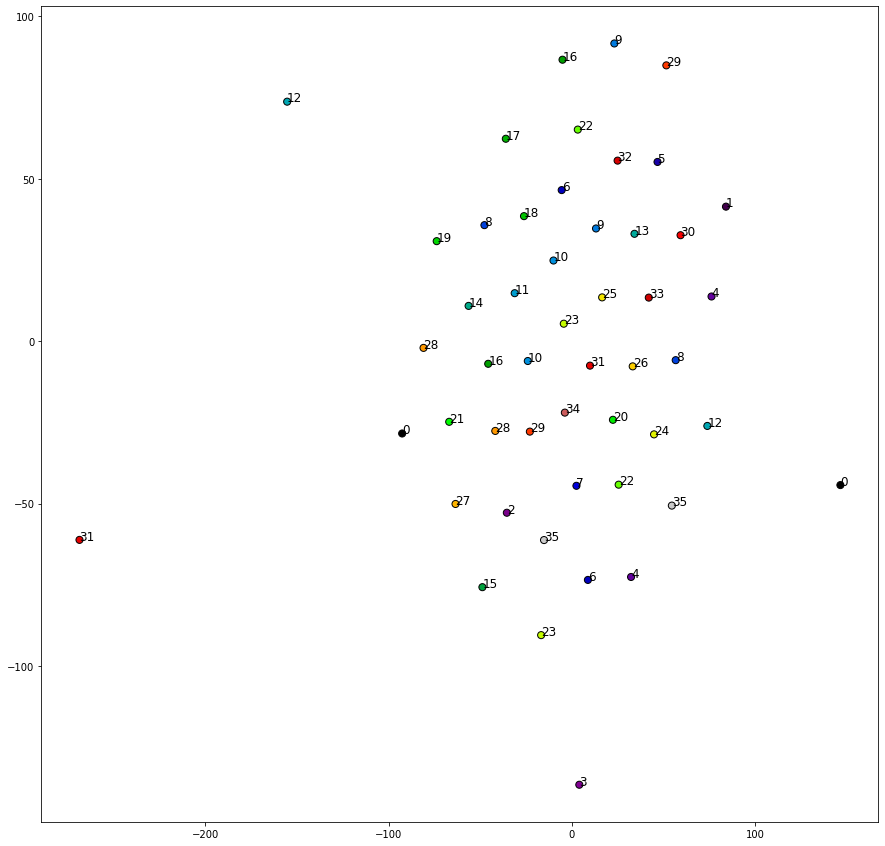

In [36]:
plt.figure(2, figsize=(15, 15))
plt.clf()

# Plot the training points
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_label, cmap=plt.cm.nipy_spectral,
            edgecolor='k',s=50,plotnonfinite=False)
plt.savefig("./plot/plot_2D_"+str(X.shape[0]))
for i, label in enumerate(y_label):
    plt.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]),fontsize=12)
plt.show()

In [32]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_data)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 7.499994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.580391
[t-SNE] KL divergence after 300 iterations: 2.388650


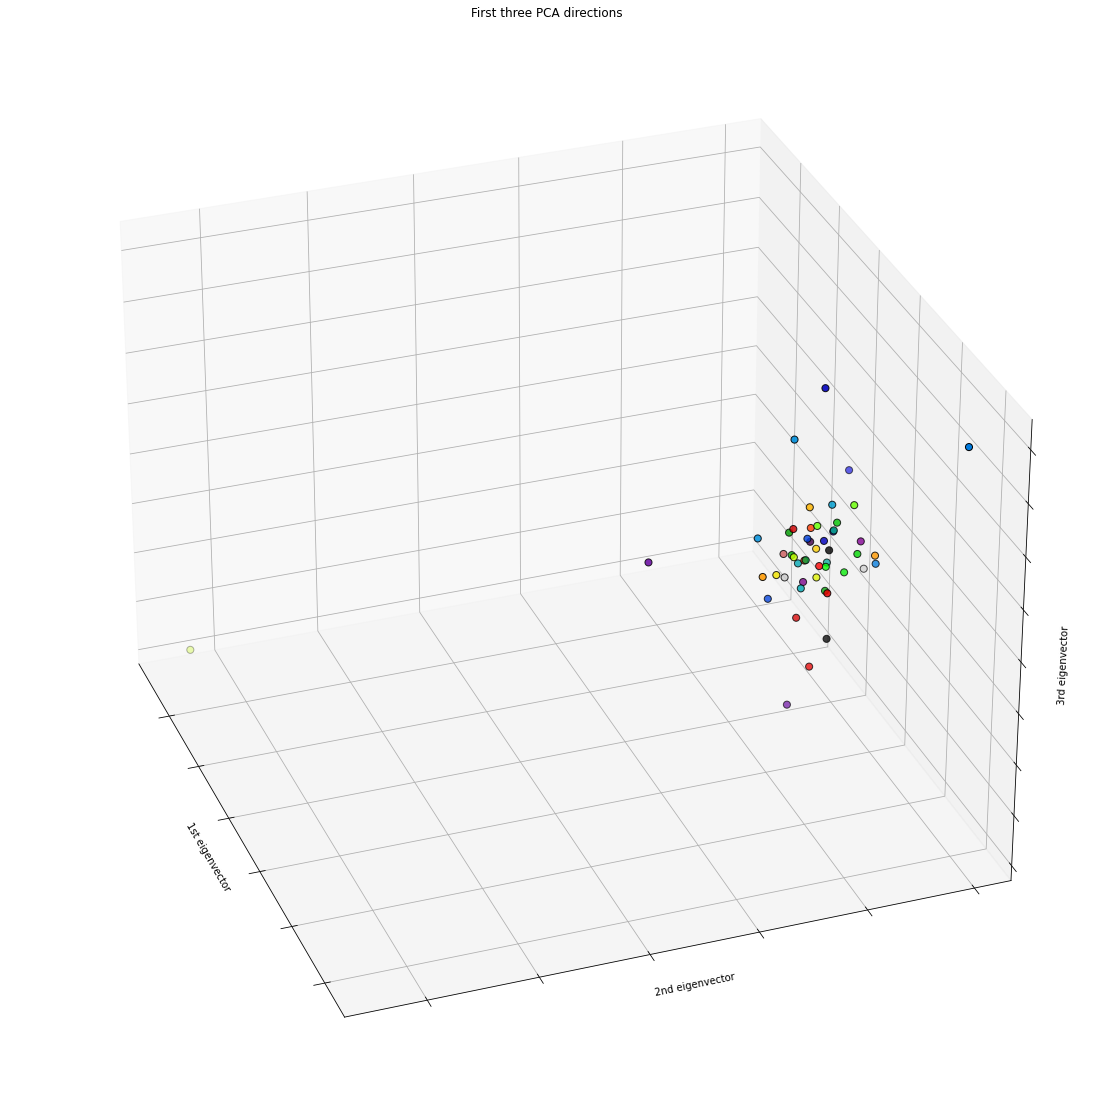

In [104]:
fig = plt.figure(1, figsize=(15, 15))
ax = Axes3D(fig, elev=-150, azim=200)
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2], c=y_label,
           cmap=plt.cm.nipy_spectral, edgecolor='k', s=50)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([]) 
#ax.savefig("./plot/plot_3D_"+str(X.shape[0])+'.pdf')
plt.show()